# SPECFEM Users Workshop -- Day 1 (Oct. 5, 2022)
## Day 1A: Intro to SPECFEM2D

- Day 1A notebook is meant to walk Users through an introduction to `SPECFEM2D`, which includes:
    1) navigating a SPECFEM2D working directory
    2) generating a 2D mesh with homogeneous halfspace model
    3) running a forward simulation to generate synthetic seismograms. 
- **Objective**: Understand `SPECFEM2D` and draw parallels to `SPECFEM3D` to better understand automation tools like `SeisFlows`.
- These instructions should be run from inside the Docker container, using Jupyter Lab (see *Docker Preamble*). 
-----------


**Relevant Links:** 
- Day 1 Slides: !!! ADD THIS !!!
- Today's Notebook: https://github.com/adjtomo/adjdocs/blob/main/workshops/2022-10-05_specfem_users/day_1a_intro_specfem.ipynb
- Completed Notebook: https://github.com/adjtomo/adjdocs/blob/main/workshops/2022-10-05_specfem_users/completed_notebooks/day_1a_intro_specfem.ipynb
- Day 0 Notebook (Container Testing): https://github.com/adjtomo/adjdocs/blob/main/workshops/2022-10-05_specfem_users/day_0_container_testing.ipynb
- SPECFEM2D GitHub Repository: https://github.com/geodynamics/specfem2d/tree/devel
- SPECFEM2D Manual: https://specfem2d.readthedocs.io/en/latest/

**Jupyter Quick Tips:**

- **Run cells** one-by-one by hitting the $\blacktriangleright$ button at the top, or by hitting `Shift + Enter`
- **Run all cells** by hitting the $\blacktriangleright\blacktriangleright$ button at the top, or by running `Run -> Run All Cells`
- **Currently running cells** that are still processing will have a `[*]` symbol next to them
- **Finished cells** will have a `[1]` symbol next to them. The number inside the brackets represents what order this cell has been run in.
- Commands that start with `!` are Bash commands (i.e., commands you would run from the terminal)
- Commands that start with `%` are Jupyter Magic commands.
- To time a task, put a `%time` before the command (e.g., `%time ! ls`)


----------
## 1) SPECFEM2D Directory Tour

- Let's start by touring around the SPECFEM2D repository, which is located in `/home/scoped/specfem2d`  
- **Note**: This directory is not the same as what you would clone from GitHub, we have removed a number of files to keep container size reasonable  
- The `devel` branch of all SPECFEM (2D/3D/3D_GLOBE) versions contains the most up to date codebase

In [15]:
# Python packages we will use on our tour
import numpy as np
import matplotlib.pyplot as plt 
from IPython.display import Image
from seisflows.tools.specfem import Model

# Make sure we're in the correct directory
%cd /home/scoped/specfem2d

/home/scoped/specfem2d


### a) SPECFEM Executables in *bin/* directory

- We have already downloaded (*git clone*), configured (*./configure*) and compiled (*make all*) SPECFEM2D   
- Executables (computer instruction sets) created by the compilation step are located in the `bin/` directory  
- Each of these executables performs a different function in the package

In [16]:
# Let's have a look at the executables
! ls bin

xadj_seismogram		      xconvolve_source_timefunction  xspecfem2D
xcheck_quality_external_mesh  xmeshfem2D		     xsum_kernels
xcombine_sem		      xsmooth_sem


The two most important executables we will be using today are `xmeshfem2D` and `xspecfem2D`. 
- `xmeshfem2D`: generate a numerical mesh, the skeleton of the domain upon which we run our numerical simulations   
- `xspecfem2D`: run the spectral element solver, generates synthetic seismograms for a given source and set of stations  

Some other important executables we will use in Days 2 and 3:
- `xsmooth_sem`: smoothing through convolution with a 2D Gaussian. Users define horizontal and vertical half-widths of the Gaussian.
- `xcombine_sem`: sums multiple volumetric quantities, used e.g., to sum multiple kernels together.

You can often run an executable to determine it's usage requirements:

In [19]:
! mpirun -n 1 bin/xcombine_sem

 Running XCOMBINE_SEM

 mpirun -n NPROC bin/xcombine_sem KERNEL_NAMES INPUT_FILE OUTPUT_DIR

 Please check command line arguments
 Error detected, aborting MPI... proc            0
Abort(30) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 30) - process 0


### b) Parameters and Simulation Data in *DATA/* directory

- *DATA/* directory contains external data and control parameters provided to SPECFEM
- The most important files are: `Par_file`, `SOURCE` and `STATIONS`
    - `Par_file`: Parameter file used to control simulation  
    - `SOURCE`: Defines source location and mechanism (e.g moment tensor, force). 
    - `STATIONS`: Defines station codes and locations (Cartesian or geographic). 


>__SOURCE NOTE__: SPECFEM2D and SPECFEM3D have a number of different types of available source files (e.g., SOURCE, FORCESOLUTION, CMTSOLUTION)  

>__STATIONS NOTE__: In SPECFEM2D, station information may also be defined in the `Par_file`
The following commands open these files for the SPECFEM2D example problem

In [21]:
def print_pretty(text):
    """Makes it easier to distinguish print statement outputs"""
    print(f"\n{'='*80}\n {text:^80}\n{'='*80}\n")

# Look at the DATA/ directory
print_pretty("DATA/ DIRECTORY")
! ls DATA/

# Illustrates that the Par_file is an ASCII file with key-value pairs
print_pretty("PARAMETER FILE (Par_file)")
! head -38 DATA/Par_file

# The SPECFEM2D SOURCE file defines a 2D seismic source
print_pretty("SOURCE FILE (SOURCE)")
! cat DATA/SOURCE

# Sometimes in SPECFEM2D, the Par_file defines station information directly
print_pretty("INTERNAL STATION DEFINITION (Par_file)")
! head -194 DATA/Par_file | tail -n 16

# However, other examples may define station information using STATIONS files, which is formatted:
print_pretty("EXTERNAL STATION DEFINITION (STATIONS)")
print("# STATION NETWORK X[m] Z[m] burial[m] elevation[m]")
! head -5 EXAMPLES/Tape2007/DATA/STATIONS_checker


                                 DATA/ DIRECTORY                                 

Par_file  SOURCE

                            PARAMETER FILE (Par_file)                            

#-----------------------------------------------------------
#
# Simulation input parameters
#
#-----------------------------------------------------------

# title of job
title                           = Test of SPECFEM2D with curved interfaces

# forward or adjoint simulation
# 1 = forward, 2 = adjoint, 3 = both simultaneously
# note: 2 is purposely UNUSED (for compatibility with the numbering of our 3D codes)
SIMULATION_TYPE                 = 1
# 0 = regular wave propagation simulation, 1/2/3 = noise simulation
NOISE_TOMOGRAPHY                = 0
# save the last frame, needed for adjoint simulation
SAVE_FORWARD                    = .false.

# parameters concerning partitioning
NPROC                           = 1              # number of processes

# time step parameters
# total number of time steps
N

### c) Results stored in *OUTPUT_FILES/* directory

- Outputs generated by SPECFEM are stored in the `OUTPUT_FILES/` directory  
- Most executables will store their outputs here unless otherwise specified  
- Outputs include: log files, error messages, synthetic seismograms, generated figures, database files etc.
- Database files store information about the mesh and model  
- **SPECFEM3D NOTE:** SPECFEM3D maintains a separate database directory (typically called `DATABASES_MPI/`).

In [22]:
# Currently empty because we have not run any executables
! ls OUTPUT_FILES

error_message000000.txt


-----------
## 2) Running the Mesher (`xmeshfem2D`)  

- The **first** thing we need to do when approaching numerical simulations is to generate a numerical mesh   
- There are multiple approaches to meshing, some include external software like [Gmsh](https://gmsh.info/) or [Trelis](https://coreform.com/products/coreform-cubit/)  
- During *this* workshop we will use SPECFEM's internal meshing software, known as `Meshfem`  
- We will use two terms to talk about meshing:  
    - **MESH**: a numerical grid which defines coordinate points only (i.e., X and Z in 2D).  
    - **MODEL**: parameter values (e.g., seismic velocity) approximating structure, assigned to locations on the MESH.  

### Mesh Examples
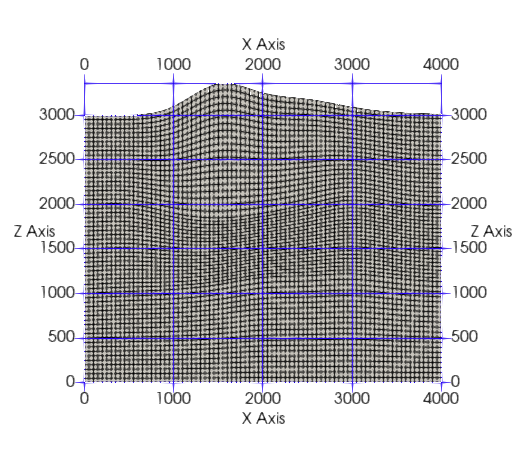
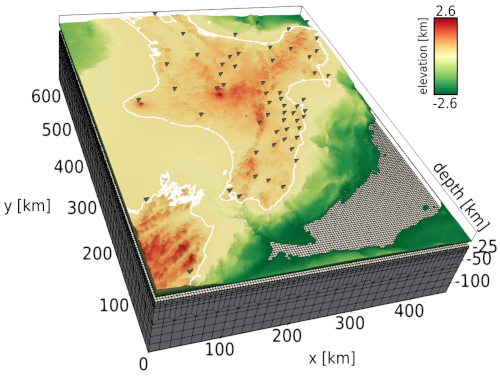


In [23]:
%cd /home/scoped/specfem2d

/home/scoped/specfem2d


### a) Model Parameters

- In SPECFEM2D, *mesh* and *model* specifications are defined in the `Par_file`  
- There are a number of parameter options we can use to customize our mesh and model   

>__SPECFEM3D NOTE:__ In SPECFEM3D, mesh files are defined in a separate `Mesh_Par_file`, typically stored in `DATA/meshfem3D_files`.

In [24]:
# Look at the definition of the model in the Par_file
! head -273 DATA/Par_file | tail -n 34

#-----------------------------------------------------------
#
# Velocity and density models
#
#-----------------------------------------------------------

# number of model materials
nbmodels                        = 4
# available material types (see user manual for more information)
#   acoustic:              model_number 1 rho Vp 0  0 0 QKappa 9999 0 0 0 0 0 0 (for QKappa use 9999 to ignore it)
#   elastic:               model_number 1 rho Vp Vs 0 0 QKappa Qmu  0 0 0 0 0 0 (for QKappa and Qmu use 9999 to ignore them)
#   anisotropic:           model_number 2 rho c11 c13 c15 c33 c35 c55 c12 c23 c25   0 QKappa Qmu
#   anisotropic in AXISYM: model_number 2 rho c11 c13 c15 c33 c35 c55 c12 c23 c25 c22 QKappa Qmu
#   poroelastic:           model_number 3 rhos rhof phi c kxx kxz kzz Ks Kf Kfr etaf mufr Qmu
#   tomo:                  model_number -1 0 0 A 0 0 0 0 0 0 0 0 0 0
#
# note: When viscoelasticity or viscoacousticity is turned on,
#       the Vp and Vs values that are read here are

- In the output above we can see that our `Par_file` defines 4 separate regions, each with varying values for density and velocity.

```bash
REG - RHO   VP[m/s] VS[m/s]    - - QKAP QMU  - - - - -
1 1 2700.d0 3000.d0 1732.051d0 0 0 9999 9999 0 0 0 0 0 0
2 1 2500.d0 2700.d0 0 0 0 9999 9999 0 0 0 0 0 0
3 1 2200.d0 2500.d0 1443.375d0 0 0 9999 9999 0 0 0 0 0 0
4 1 2200.d0 2200.d0 1343.375d0 0 0 9999 9999 0 0 0 0 0 0
```
- These regions have **no** sense of space. They only represent material properties.
- These regions will be assigned to parts of the *mesh* in the following section

### b) Mesh Parameters

- The internal mesher has a set of parameters that allows Users to provide: interfaces, geometry, boundary conditions.
    - **Interfaces** define the contact point between two mesh domains. Across an interface, mesh geometry and model parameters can change.
    - **Boundary conditions** define how waves interact with the edges of your finite domain. Often absorbing boundary conditions are used.
    - **Mesh geometry** can be optimized to reduce computational cost while keeping simulations stable.

In [25]:
! head -320 DATA/Par_file | tail -n 29

#-----------------------------------------------------------
#
# PARAMETERS FOR INTERNAL MESHING
#
#-----------------------------------------------------------

# file containing interfaces for internal mesh
interfacesfile                  = ../EXAMPLES/simple_topography_and_also_a_simple_fluid_layer/DATA/interfaces_simple_topo_curved.dat

# geometry of the model (origin lower-left corner = 0,0) and mesh description
xmin                            = 0.d0           # abscissa of left side of the model
xmax                            = 4000.d0        # abscissa of right side of the model
nx                              = 80             # number of elements along X

# absorbing boundary parameters (see absorbing_conditions above)
absorbbottom                    = .true.
absorbright                     = .true.
absorbtop                       = .false.
absorbleft                      = .true.

# define the different regions of the model in the (nx,nz) spectral-element mesh
nbregions       

- In Meshfem2D we can set any of the 4 edges to be absoring
- The top boundary is often not absoring, to mimic surface reflections as you would have in the real world
- The section at the bottom partitions *materials* defined by the model, to *regions* of the mesh
- A separate *interface* file defines the shape of boundaries within the mesh

In [26]:
# Let's have a look at the `interfaces` file which defines boundary interfaces 
! cat /home/scoped/specfem2d/EXAMPLES/simple_topography_and_also_a_simple_fluid_layer/DATA/interfaces_simple_topo_curved.dat

# number of interfaces
 4
#
# for each interface below, we give the number of points and then x,z for each point
#
# interface number 1 (bottom of the mesh)
 2
 0 0
 5000 0
# interface number 2
 7
    0 1000
 1500 1100
 2000 1180
 2500 1200
 3000 1220
 3500 1170
 5000 1100
# interface number 3
 9
    0 2000
  500 2000
 1000 1900
 1500 1847
 2000 1900
 2500 2000
 3000 2090
 3500 2020
 5000 2000
# interface number 4 (topography, top of the mesh)
 8
    0 3000
  500 3000
 1000 3100
 1500 3350
 2000 3250
 2500 3180
 3000 3090
 5000 3000
#
# for each layer, we give the number of spectral elements in the vertical direction
#
# layer number 1 (bottom layer)
 20
# layer number 2
 20
# layer number 3 (top layer)
 20


- There are 4 interfaces defined in this file (bottom of mesh, 2 internal interfaces, top of mesh)  
- The bottom of the mesh has a flat boundary  
- The other 3 interfaces (including top of mesh, a.k.a topography) are curved  
- We define 20 elements in each layer for 60 total elements in the Z direction

### c) Setting Up Meshfem

- We need to set a few `Par_file` parameters to tell SPECFEM to output additional files that will facilitate our tour of `xmeshfem2D`.
- In your work, you can use a text editor to edit the `Par_file`, or bash commands like 'cat' + 'awk'  
- Here, for convenience, we introduce the `SeisFlows` command line tool, which provides Python-based utility functions 
- We will use the `seisflows sempar` commmand line utility to print and edit values from the SPECFEM2D `Par_file`. 


**SEMPAR NOTE**: The `sempar` (spectral element method parameter) command syntax is as follows
```python
seisflows sempar -P <Par_file> <key> <value:optional>
```
- \<Par_file> is the path the SPECFEM `Par_file`
- \<key> represents a parameter in the par file (case-insensitive) 
- \<value> is an optional parameter to overwrite an existing parameter. 
    

In [27]:
! seisflows sempar -P DATA/Par_file model 
! seisflows sempar -P DATA/Par_file nproc 4
! seisflows sempar -P DATA/Par_file setup_with_binary_database 1
! seisflows sempar -P DATA/Par_file save_model binary

MODEL: default
NPROC: 1 -> 4
setup_with_binary_database: 0 -> 1
SAVE_MODEL: default -> binary


#### Meshfem Parameter Explanations

`MODEL`: Must be 'default' to use the model defined in the `Par_file` (this is the default option)  
`NPROC`: Number of MPI processes to run on. The mesh itself is partitioned into `NPROC` sections, each of which is provided to a separate processor  
`setup_with_binary_database`: Writes database files in FORTRAN Binary format, by default they are *not* saved  
`SAVE_MODEL`: Write the model out in FORTRAN Binary format. As opposed to other formats like ASCII

#### Database Files

- Database files store SPECFEM's internal representation of mesh and model
- These can take on various formats, here they are FORTRAN Binary files
- SPECFEM3D operates similarly, storing mesh and model representations as DATABASE files

### d) Run Meshfem Executable

- The SPECFEM2D example problem is already set up, so we simply execute `xmeshfem2D` with MPI
- SPECFEM will look for relevant data in the *DATA/* directory
- It will generate a numerical mesh in the *OUTPUT_FILES/* directory. 
- The *model* will **not** be output until we run the solver (`xspecfem2D`) later in the notebook

In [30]:
# Run the mesher and re-direct output to a text file
! mpirun -n 4 bin/xmeshfem2D > OUTPUT_FILES/output_meshfem2d.txt

# The log file contains important information on how the mesher ran
! head OUTPUT_FILES/output_meshfem2d.txt
! echo "..."
! tail OUTPUT_FILES/output_meshfem2d.txt


 **********************************************
 *** Specfem 2-D Mesher - MPI version       ***
 **********************************************

 Running Git version of the code corresponding to commit 604f766101c9ece3d588d61e6275d81d50dd8e65
 dating From Date:   Thu Sep 22 12:55:08 2022 +0200

 Reading the parameter file...

...
 Receiver           16  =    2500.0000000000000        1500.0000000000000     
 Receiver           17  =    2500.0000000000000        1250.0000000000000     
 Receiver           18  =    2500.0000000000000        1000.0000000000000     
 Receiver           19  =    2500.0000000000000        750.00000000000000     
 Receiver           20  =    2500.0000000000000        500.00000000000000     
 Receiver           21  =    2500.0000000000000        250.00000000000000     
 Receiver           22  =    2500.0000000000000        0.0000000000000000     

 This will be a parallel simulation on            4  processor cores



In [31]:
# e.g., the mesher has created our STATIONS File
! head -255 OUTPUT_FILES/output_meshfem2d.txt | tail -n 30


 writing the ./DATA/STATIONS file


 There are           22  receivers

 Target positions (x,z) of the           22  receivers

 Receiver            1  =    300.00000000000000        2997.7298908673174     
 Receiver            2  =    640.00000000000000        3008.0430011257899     
 Receiver            3  =    980.00000000000000        3090.8224062492818     
 Receiver            4  =    1320.0000000000000        3283.0303922802987     
 Receiver            5  =    1660.0000000000000        3347.8768862033312     
 Receiver            6  =    2000.0000000000000        3250.0000000000000     
 Receiver            7  =    2340.0000000000000        3197.3138031016656     
 Receiver            8  =    2680.0000000000000        3150.9619872716830     
 Receiver            9  =    3020.0000000000000        3086.5939051292362     
 Receiver           10  =    3360.0000000000000        3042.8523748190692     
 Receiver           11  =    3700.0000000000000        3020.6886767662263     
 R

In [32]:
# The STATIONS file matches what the log file tells us 
! cat DATA/STATIONS

S0001    AA          300.0000000         2997.7298909       0.0         0.0
S0002    AA          640.0000000         3008.0430011       0.0         0.0
S0003    AA          980.0000000         3090.8224062       0.0         0.0
S0004    AA         1320.0000000         3283.0303923       0.0         0.0
S0005    AA         1660.0000000         3347.8768862       0.0         0.0
S0006    AA         2000.0000000         3250.0000000       0.0         0.0
S0007    AA         2340.0000000         3197.3138031       0.0         0.0
S0008    AA         2680.0000000         3150.9619873       0.0         0.0
S0009    AA         3020.0000000         3086.5939051       0.0         0.0
S0010    AA         3360.0000000         3042.8523748       0.0         0.0
S0011    AA         3700.0000000         3020.6886768       0.0         0.0
S0012    AA         2500.0000000         2500.0000000       0.0         0.0
S0013    AA         2500.0000000         2250.0000000       0.0         0.0
S0014    AA 

In [33]:
# Database files are stored in the OUTPUT_FILES/ directory as FORTRAN binary (.bin) files
! ls OUTPUT_FILES/Database*.bin

OUTPUT_FILES/Database00000.bin	OUTPUT_FILES/Database00002.bin
OUTPUT_FILES/Database00001.bin	OUTPUT_FILES/Database00003.bin


In [34]:
# SPECFEM also outputs Visualization Toolkit (.vtk) files which
# can be used for visualization using external software
! ls OUTPUT_FILES/*.vtk

OUTPUT_FILES/mesh_materials.vtk  OUTPUT_FILES/mesh_partition_number.vtk


---------
## 3) Running the Solver `xspecfem2D`

- The Solver `xspecfem2D` will now take the Database files generated by `xmeshfem2D` and run a wave propagation simulation  
- `xspecfem2D` uses the provided `SOURCE` to initiate a force in the domain and the resulting wave propagation
- The propagating wavefield is simulated across the **entire** domain  
- The `STATIONS` files tells SPECFEM where to **store** waveforms generated by the propagating wavefield
- These files are **synthetic seismograms** and mimic real-world recordings made by seismometers  

In [35]:
%cd /home/scoped/specfem2d

/home/scoped/specfem2d


In [38]:
# Let's look at some Solver-specific parameters
! head -168 DATA/Par_file | tail -n 32

#-----------------------------------------------------------
#
# Receivers
#
#-----------------------------------------------------------

# receiver set parameters for recording stations (i.e. recording points)
# seismotype : record 1=displ 2=veloc 3=accel 4=pressure 5=curl of displ 6=the fluid potential
seismotype                      = 1              # several values can be chosen. For example : 1,2,4

# interval in time steps for writing of seismograms
# every how many time steps we save the seismograms
# (costly, do not use a very small value; if you use a very large value that is larger than the total number
#  of time steps of the run, the seismograms will automatically be saved once at the end of the run anyway)
NTSTEP_BETWEEN_OUTPUT_SEISMOS   = 10000

# set to n to reduce the sampling rate of output seismograms by a factor of n
# defaults to 1, which means no down-sampling
NTSTEP_BETWEEN_OUTPUT_SAMPLE    = 1

# so far, this option can only be used if all the receivers are in a

### Some Important Solver Parameters

`seismotype`: Set units of the output synthetic seismograms. Here we output 'displacement' in SI unit meters.
`USER_T0`: Defines the earlist starting time is, prior to time step 0. This allows some zero padding before initiating the source  
`save_ASCII_seismograms`: Outputs seismograms in two-column ASCII files  

In [40]:
# Run the solver on 4 cores, re-direct output log
! mpirun -n 4 bin/xspecfem2D > OUTPUT_FILES/output_solver.txt

# Again, the log file contains important information on the process
! head OUTPUT_FILES/output_solver.txt
! echo "..."
! tail OUTPUT_FILES/output_solver.txt


 **********************************************
 **** Specfem 2-D Solver - MPI version     ****
 **********************************************

 Running Git version of the code corresponding to commit 604f766101c9ece3d588d61e6275d81d50dd8e65
 dating From Date:   Thu Sep 22 12:55:08 2022 +0200

 There are            4  MPI processes
 Processes are numbered from 0 to            3
...
 -------------------------------------------------------------------------------
 Program SPECFEM2D: 
 -------------------------------------------------------------------------------
 -------------------------------------------------------------------------------
 Test of SPECFEM2D with curved interfaces
 -------------------------------------------------------------------------------
 -------------------------------------------------------------------------------
 D a t e : 29 - 09 - 2022                                 T i m e  : 19:11:26
 ------------------------------------------------------------------

In [41]:
# Mesh and Model parameters are assigned here
! head -280 OUTPUT_FILES/output_solver.txt | tail -n 16

 Mesh dimensions:
   Xmin,Xmax of the whole mesh =    0.0000000000000000        4000.0000000000005     
   Zmin,Zmax of the whole mesh =    0.0000000000000000        3355.8363405549972     

 Material properties:
   MODEL                 : default
   nspec                 :         4800
   assign external model :  F

   setting up material arrays
   all material arrays done

 Domains:
   total number of acoustic elements        =         1380
   total number of elastic elements         =         3420
   total number of poroelastic elements     =            0


In [56]:
# During the simulation, the log file updates the User on progress
! head -1033 OUTPUT_FILES/output_solver.txt | tail -n 32

 ******************************************************************
Time step number     500   t =    0.5489 s out of    1600
 ******************************************************************
 We have done    31.2070045     % of the total
 Max norm of vector field in solid (elastic) =    9.34773833E-02
 Max absolute value of scalar field in fluid (acoustic) =    5218.36914    
 Elapsed time in seconds =    5.7599999904632568     
 Elapsed time in hh:mm:ss =      0 h 00 m 05 s
 Mean elapsed time per time step in seconds =    1.1519999980926513E-002
 Time steps remaining =         1100
 Estimated remaining time in seconds =    12.671999979019164     
 Estimated remaining time in hh:mm:ss =      0 h 00 m 12 s
 Estimated total run time in seconds =    18.431999969482419     
 Estimated total run time in hh:mm:ss =      0 h 00 m 18 s
 The run will finish approximately on: Thu Sep 29, 2022 19:11


 Writing PostScript vector plot for time step          500
 drawing displacement vector as sm

In [61]:
# The solver writes out model files at the end of the simulation
! tail -n 25 OUTPUT_FILES/output_solver.txt


 Saving model files to directory: ./DATA/
   SAVE_MODEL type: binary

   written to file(s): ./DATA/proc000000_rho.bin
   written to file(s): ./DATA/proc000000_vp.bin
   written to file(s): ./DATA/proc000000_vs.bin
   written to file(s): ./DATA/proc000000_x.bin
   written to file(s): ./DATA/proc000000_z.bin
   written to file(s): ./DATA/proc000000_jacobian.bin

   done


 -------------------------------------------------------------------------------
 -------------------------------------------------------------------------------
 Program SPECFEM2D: 
 -------------------------------------------------------------------------------
 -------------------------------------------------------------------------------
 Test of SPECFEM2D with curved interfaces
 -------------------------------------------------------------------------------
 -------------------------------------------------------------------------------
 D a t e : 29 - 09 - 2022                                 T i m e  : 19:11:2

-------------
## 4) Understanding SPECFEM2D Output Files

- `xspecfem2D` has created a number of output files
- These files include a log message, additional DATABASE files, synthetic seismograms, and the output model

In [63]:
%cd /home/scoped/specfem2d

# For example, the DATA/*.bin files define our velocity model
! ls DATA/*bin

/home/scoped/specfem2d
DATA/proc000000_jacobian.bin	 DATA/proc000002_jacobian.bin
DATA/proc000000_NSPEC_ibool.bin  DATA/proc000002_NSPEC_ibool.bin
DATA/proc000000_rho.bin		 DATA/proc000002_rho.bin
DATA/proc000000_vp.bin		 DATA/proc000002_vp.bin
DATA/proc000000_vs.bin		 DATA/proc000002_vs.bin
DATA/proc000000_x.bin		 DATA/proc000002_x.bin
DATA/proc000000_z.bin		 DATA/proc000002_z.bin
DATA/proc000001_jacobian.bin	 DATA/proc000003_jacobian.bin
DATA/proc000001_NSPEC_ibool.bin  DATA/proc000003_NSPEC_ibool.bin
DATA/proc000001_rho.bin		 DATA/proc000003_rho.bin
DATA/proc000001_vp.bin		 DATA/proc000003_vp.bin
DATA/proc000001_vs.bin		 DATA/proc000003_vs.bin
DATA/proc000001_x.bin		 DATA/proc000003_x.bin
DATA/proc000001_z.bin		 DATA/proc000003_z.bin


### a) Velocity Model

- `xspecfem2D` outputs the velocity model to the *DATA/* directory  
- We can use some SeisFlows utility functions to plot this model to help us visualize our domain  
- During your research, there are a number of tools you can use to visualize your simulation results  
- **SPECFEM3D NOTE**: SPECFEM3D outputs velocity model files to the `Par_file` parameter `LOCAL_PATH`, commonly `OUTPUT_FILES/DATABASES_MPI`

/home/scoped/seisflows/seisflows/tools/specfem.py:546: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = np.array(array)


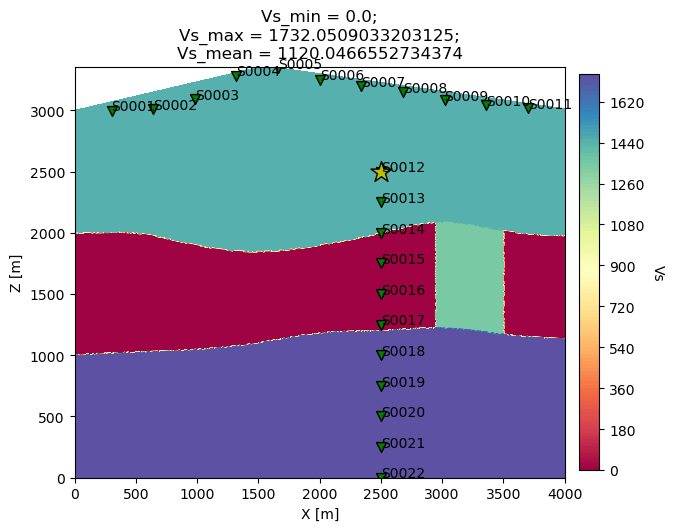

In [69]:
# Grab STATION coordinates by reading ACSII files
sta_x, sta_z = np.genfromtxt("DATA/STATIONS", dtype=float, usecols=[2, 3]).T
sta_id = np.genfromtxt("DATA/STATIONS", dtype=str, usecols=[0]).T

# Grab SOURCE coordinates from SOURCE file
source_file = f"DATA/SOURCE"
with open(source_file, "r") as f:
    lines = f.readlines()
    
# Trying to break apart the following line
# 'xs = 299367.72      # source location x in meters\n'
ev_x = float(lines[2].split("=")[1].split("#")[0].strip())
ev_z = float(lines[3].split("=")[1].split("#")[0].strip())

# Use SeisFlows 'Model' class to plot the 2D model 
m = Model(path="DATA")
m.plot2d(parameter="vs", show=False)

# Plot SOURCE and STATIONS on top of the model
for x_, z_, id_ in zip(sta_x, sta_z, sta_id):
    plt.scatter(float(x_), float(z_), c="g", marker="v", ec="k", s=50)
    plt.text(x_, z_, id_)
plt.scatter(ev_x, ev_z, c="y", marker="*", ec="k", s=250)

- The model above shows shear wave velocities (Vs in m/s) in a 2D domain
- Our model is defined by 3 distinct layers (compare to interfaces file previously). 
    - Top: Z=3500m to Z=2000m, features a moderate velocity with topography at the surface (Z>3000m). 
    - Middle: Z=2000m to Z=1000m shows a low velocity zone with a high-velocity column (turquoise square). 
    - Bottom: Z=1000m to Z=0m, features a realtively fast velocity. 
- 22 Station locations (green triangles), along the top boundary, and in a 'borehole' below the event
- 1 event (yellow star) colocated with station S0012

In [70]:
# We can compare the interface file with the mesh above
! head -39 EXAMPLES/simple_topography_and_also_a_simple_fluid_layer/DATA/interfaces_simple_topo_curved.dat | tail -n 34

# interface number 1 (bottom of the mesh)
 2
 0 0
 5000 0
# interface number 2
 7
    0 1000
 1500 1100
 2000 1180
 2500 1200
 3000 1220
 3500 1170
 5000 1100
# interface number 3
 9
    0 2000
  500 2000
 1000 1900
 1500 1847
 2000 1900
 2500 2000
 3000 2090
 3500 2020
 5000 2000
# interface number 4 (topography, top of the mesh)
 8
    0 3000
  500 3000
 1000 3100
 1500 3350
 2000 3250
 2500 3180
 3000 3090
 5000 3000


### b) Synthetic waveforms

- During the simulation, `xspecfem2D` initiated the `SOURCE` file at time T=0  
- Over the course of the simulation, seismic waves propogated outward and were recorded at receiver locations defined by `STATIONS`   
- Each `STATION` has a corresponding synthetic seismogram located in the *OUTPUT_FILES/* directory.
- Synthetic seismograms have file extension `.semd` because they are output in displacement (set by parameter `seismotype`)  
- 'd' in .semd stands for displacement. Velocity seismograms would be extension'ed `.semv`, acceleration `.sema`. **This is the same in SPECFEM3D**
- For simplicity we have chosen to output our synthetics in ACSII format. These ASCII files are two columns, representing time and amplitude, respectively.

In [71]:
# We have generated synthetics for each station location shown above
! ls OUTPUT_FILES/*.semd
! echo
# The first 10 lines of a seismogram show the two-column (time, amplitude) format
! head -10 OUTPUT_FILES/AA.S0001.BXX.semd

OUTPUT_FILES/AA.S0001.BXX.semd	OUTPUT_FILES/AA.S0012.BXX.semd
OUTPUT_FILES/AA.S0001.BXZ.semd	OUTPUT_FILES/AA.S0012.BXZ.semd
OUTPUT_FILES/AA.S0002.BXX.semd	OUTPUT_FILES/AA.S0013.BXX.semd
OUTPUT_FILES/AA.S0002.BXZ.semd	OUTPUT_FILES/AA.S0013.BXZ.semd
OUTPUT_FILES/AA.S0003.BXX.semd	OUTPUT_FILES/AA.S0014.BXX.semd
OUTPUT_FILES/AA.S0003.BXZ.semd	OUTPUT_FILES/AA.S0014.BXZ.semd
OUTPUT_FILES/AA.S0004.BXX.semd	OUTPUT_FILES/AA.S0015.BXX.semd
OUTPUT_FILES/AA.S0004.BXZ.semd	OUTPUT_FILES/AA.S0015.BXZ.semd
OUTPUT_FILES/AA.S0005.BXX.semd	OUTPUT_FILES/AA.S0016.BXX.semd
OUTPUT_FILES/AA.S0005.BXZ.semd	OUTPUT_FILES/AA.S0016.BXZ.semd
OUTPUT_FILES/AA.S0006.BXX.semd	OUTPUT_FILES/AA.S0017.BXX.semd
OUTPUT_FILES/AA.S0006.BXZ.semd	OUTPUT_FILES/AA.S0017.BXZ.semd
OUTPUT_FILES/AA.S0007.BXX.semd	OUTPUT_FILES/AA.S0018.BXX.semd
OUTPUT_FILES/AA.S0007.BXZ.semd	OUTPUT_FILES/AA.S0018.BXZ.semd
OUTPUT_FILES/AA.S0008.BXX.semd	OUTPUT_FILES/AA.S0019.BXX.semd
OUTPUT_FILES/AA.S0008.BXZ.semd	OUTPUT_FILES/AA.S0019.BXZ.semd
OUTPUT_F

Text(0, 0.5, 'Displacement [m]')

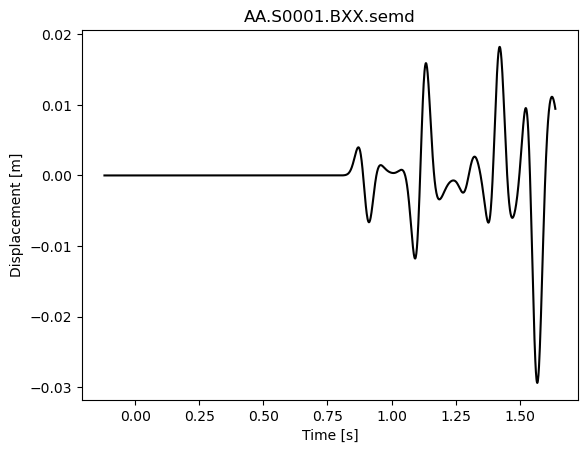

In [73]:
# We can easily plot seismograms using NumPy and Matplotlib
data = np.loadtxt("OUTPUT_FILES/AA.S0001.BXX.semd", dtype=float)
plt.plot(data[:,0], data[:,1], c="k")
plt.title("AA.S0001.BXX.semd")
plt.xlabel("Time [s]")
plt.ylabel("Displacement [m]")

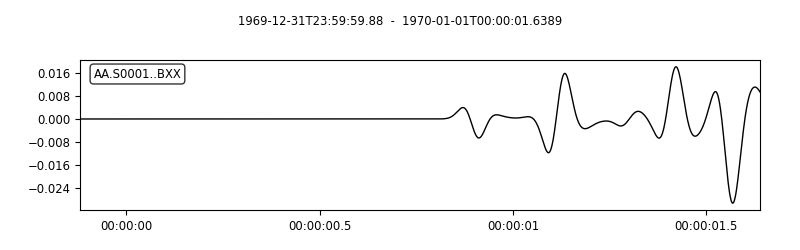

In [74]:
# SeisFlows also has a simple command line tool to plot seismograms using ObsPy
! seisflows plotst OUTPUT_FILES/AA.S0001.BXX.semd --savefig AA.S0001.BXX.semd.png
Image("AA.S0001.BXX.semd.png")

[2022-09-29 19:26:45] - pysep - INFO: starting record section plotter
[2022-09-29 19:26:45] - pysep - INFO: Reading 44 synthetics from: OUTPUT_FILES/
[2022-09-29 19:26:45] - pysep - DEBUG: OUTPUT_FILES/AA.S0013.BXZ.semd
[2022-09-29 19:26:45] - pysep - DEBUG: OUTPUT_FILES/AA.S0016.BXZ.semd
[2022-09-29 19:26:45] - pysep - DEBUG: OUTPUT_FILES/AA.S0005.BXX.semd
[2022-09-29 19:26:45] - pysep - DEBUG: OUTPUT_FILES/AA.S0016.BXX.semd
[2022-09-29 19:26:45] - pysep - DEBUG: OUTPUT_FILES/AA.S0005.BXZ.semd
[2022-09-29 19:26:45] - pysep - DEBUG: OUTPUT_FILES/AA.S0014.BXX.semd
[2022-09-29 19:26:45] - pysep - DEBUG: OUTPUT_FILES/AA.S0017.BXX.semd
[2022-09-29 19:26:45] - pysep - DEBUG: OUTPUT_FILES/AA.S0002.BXX.semd
[2022-09-29 19:26:45] - pysep - DEBUG: OUTPUT_FILES/AA.S0004.BXX.semd
[2022-09-29 19:26:45] - pysep - DEBUG: OUTPUT_FILES/AA.S0011.BXX.semd
[2022-09-29 19:26:45] - pysep - DEBUG: OUTPUT_FILES/AA.S0018.BXZ.semd
[2022-09-29 19:26:45] - pysep - DEBUG: OUTPUT_FILES/AA.S0019.BXZ.semd
[2022-09-2

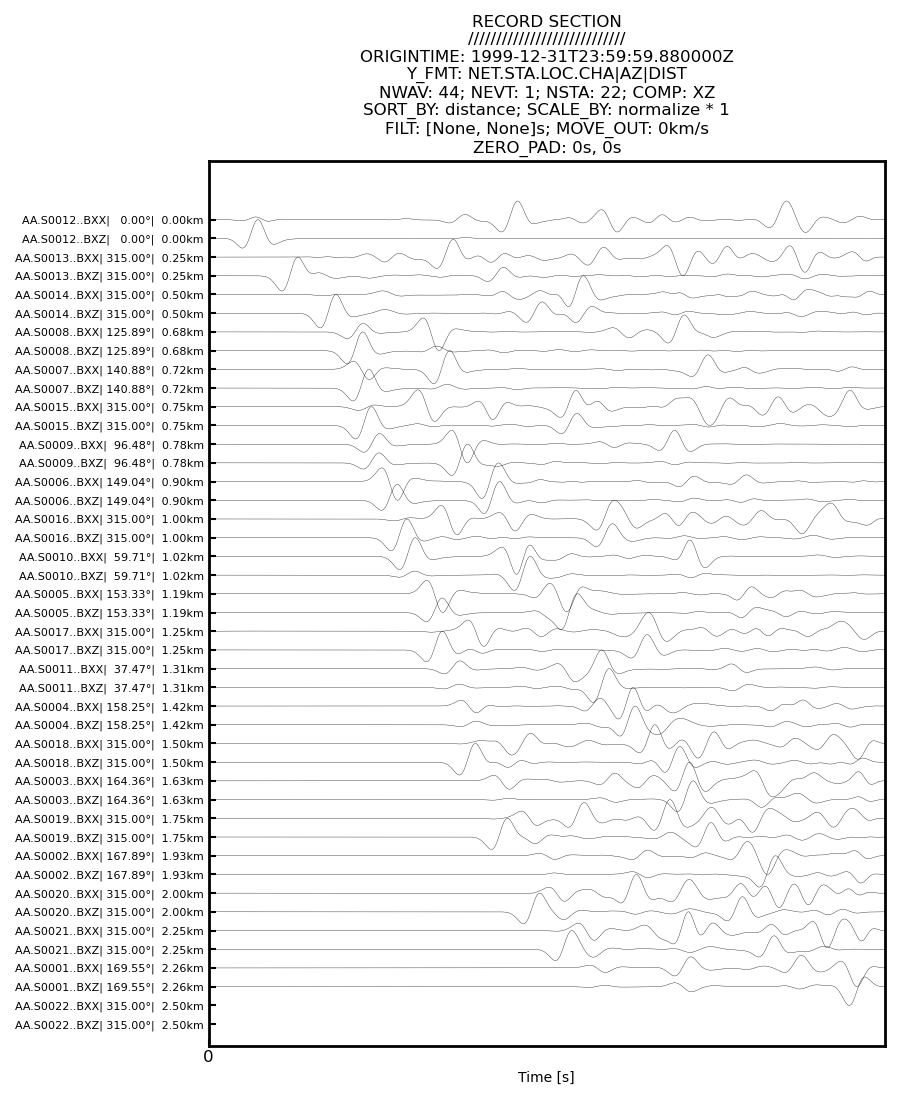

In [78]:
# We can use PySEP's record section (RecSec) tool to plot SPECFEM2D synthetics
# Note: because SPECFEM2D's SOURCE files don't contain origin time information, RecSec uses a dummy time
! recsec --syn_path OUTPUT_FILES/ --cmtsolution DATA/SOURCE --stations DATA/STATIONS --components XZ --cartesian --overwrite
Image("record_section.png")

### c) SPECFEM2D Wavefield Snapshots 

- `xspecfem2D` generates snapshots of the forward wavefield, automatically generated during a simulation as .jpg files  
- The `Par_file` parameter `NTSTEP_BETWEEN_OUTPUT_IMAGES` controls how often figures are generated during a simulation. 
- We can see below that `DT`=.0011, so we output images every 0.11s of simulation time. 

In [79]:
# Use sempar to display parameter values
! seisflows sempar -P DATA/Par_file ntstep_between_output_images
! seisflows sempar -P DATA/Par_file dt

NTSTEP_BETWEEN_OUTPUT_IMAGES: 100
DT: 0.0011


In [80]:
# Wavefield snapshots every 100 time steps
! ls OUTPUT_FILES/*.jpg

OUTPUT_FILES/forward_image000000005.jpg
OUTPUT_FILES/forward_image000000100.jpg
OUTPUT_FILES/forward_image000000200.jpg
OUTPUT_FILES/forward_image000000300.jpg
OUTPUT_FILES/forward_image000000400.jpg
OUTPUT_FILES/forward_image000000500.jpg
OUTPUT_FILES/forward_image000000600.jpg
OUTPUT_FILES/forward_image000000700.jpg
OUTPUT_FILES/forward_image000000800.jpg
OUTPUT_FILES/forward_image000000900.jpg
OUTPUT_FILES/forward_image000001000.jpg
OUTPUT_FILES/forward_image000001100.jpg
OUTPUT_FILES/forward_image000001200.jpg
OUTPUT_FILES/forward_image000001300.jpg
OUTPUT_FILES/forward_image000001400.jpg
OUTPUT_FILES/forward_image000001500.jpg
OUTPUT_FILES/forward_image000001600.jpg


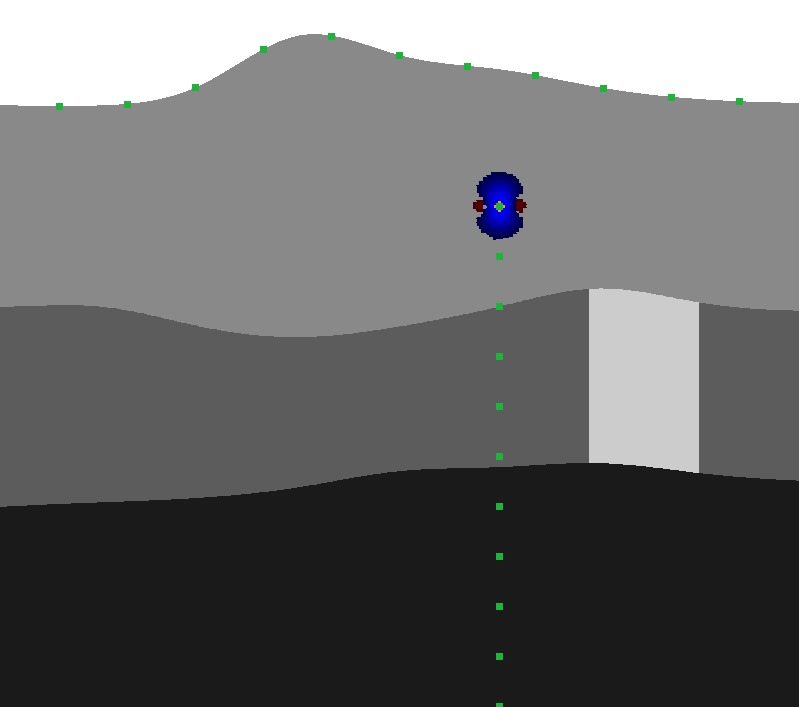

In [81]:
# Forward wavefield at NSTEP=100, T=.11s
Image("OUTPUT_FILES/forward_image000000100.jpg")

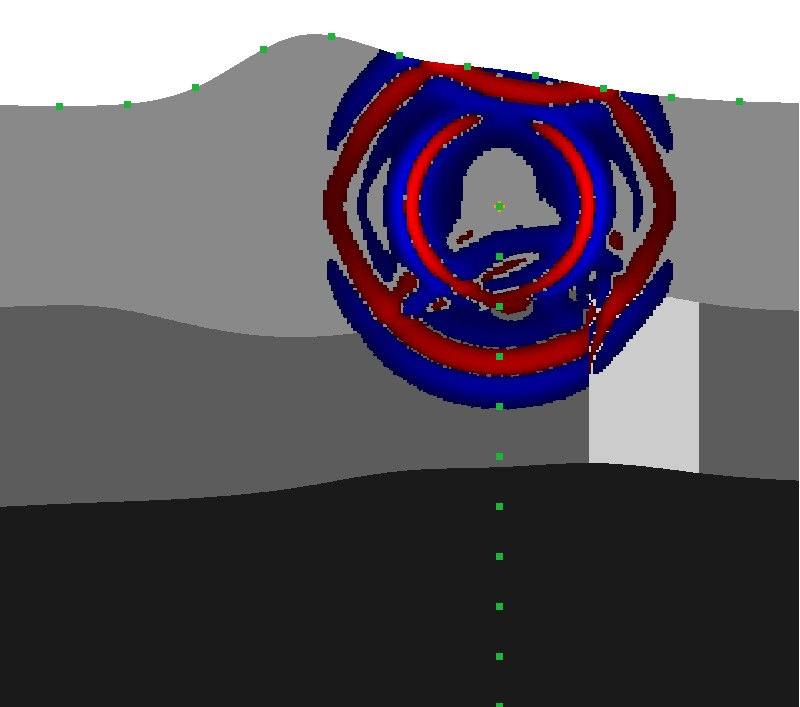

In [82]:
# Forward wavefield at NSTEP=400, T=.44s
Image("OUTPUT_FILES/forward_image000000400.jpg")

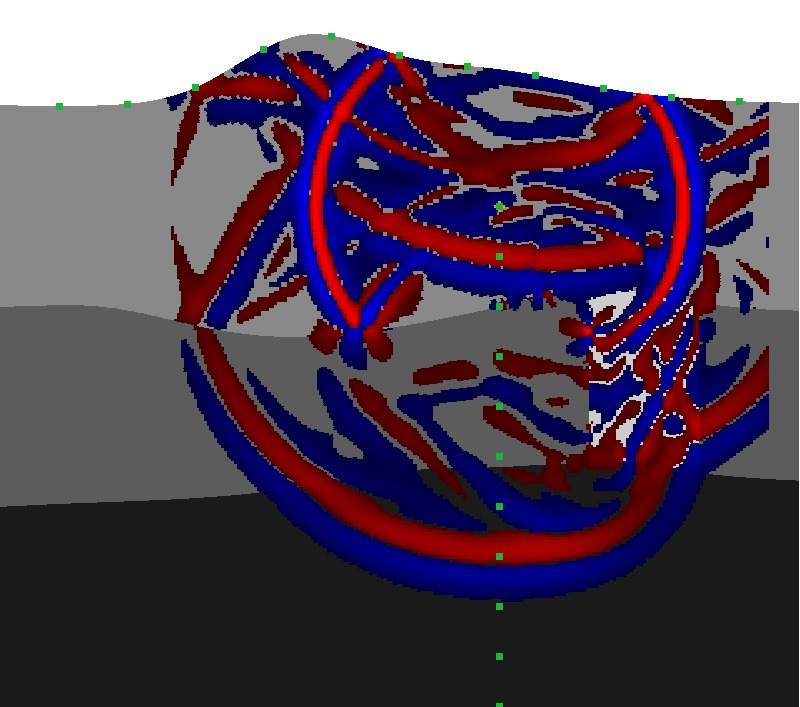

In [83]:
# Forward wavefield at NSTEP=700, T=.77s
Image("OUTPUT_FILES/forward_image000000700.jpg")

-------------
## 5) Conclusions

- In this notebook we explored SPECFEM2D, and learned to run the default example mesh generation and forward simulation.  
- We took a look at the most important files required for a simulation, and how User's can manipulate various parameters and files to run their own simulations. 
- We had a look at the results of a SPECFEM2D simulation, including waveforms, models, and wavefield snapshots.